# Módulo 05 - Detecção de Objetos coom YOLOv8

Neste módulo de introdução às técnicas de Processamento de Imagem, você vai conhecer os fundamentos da manipulação da imagem, além de desenvolver projetos como chroma keying e detecção de desmatamento a partir de imagens de satélites.

---

Os exemplos foram construídos com base nos materiais disponibilizados pela Roboflow, através do tutorial de Piotr Skalski disponível em [roboflow/notebooks.](https://github.com/roboflow/notebooks/tree/main?tab=readme-ov-file)

In [1]:
!nvidia-smi

Mon Feb 19 17:11:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Instalar Ultralytics (YOLOv8)

In [2]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
print(ultralytics.checks())

Ultralytics YOLOv8.1.16 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)
None


In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M3UuH3QNDWGiH0NmGgHtIgXXGDo_nigm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1M3UuH3QNDWGiH0NmGgHtIgXXGDo_nigm" -O mall.mp4 && rm -rf /tmp/cookies.txt

display.clear_output()

!ls

mall.mp4


In [4]:
MALL_PATH = "mall.mp4"

In [5]:
import cv2
import numpy as np
from ultralytics import YOLO

# 1. Criar Modelo
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 205MB/s]


In [6]:
!pip install supervision
display.clear_output()

import supervision as sv
print("Supervision", sv.__version__)

Supervision 0.18.0


In [7]:
import cv2
import numpy as np
from ultralytics import YOLO

# 1. Criar Modelo
model = YOLO("yolov8s.pt")

In [8]:
generator = sv.get_video_frames_generator(MALL_PATH)

frame = next(generator)
# cv2.imwrite("frame_reference.jpg", frame)



0: 736x1280 1 person, 4 bottles, 1 chair, 1 tv, 2 refrigerators, 425.3ms
Speed: 61.0ms preprocess, 425.3ms inference, 1631.9ms postprocess per image at shape (1, 3, 736, 1280)


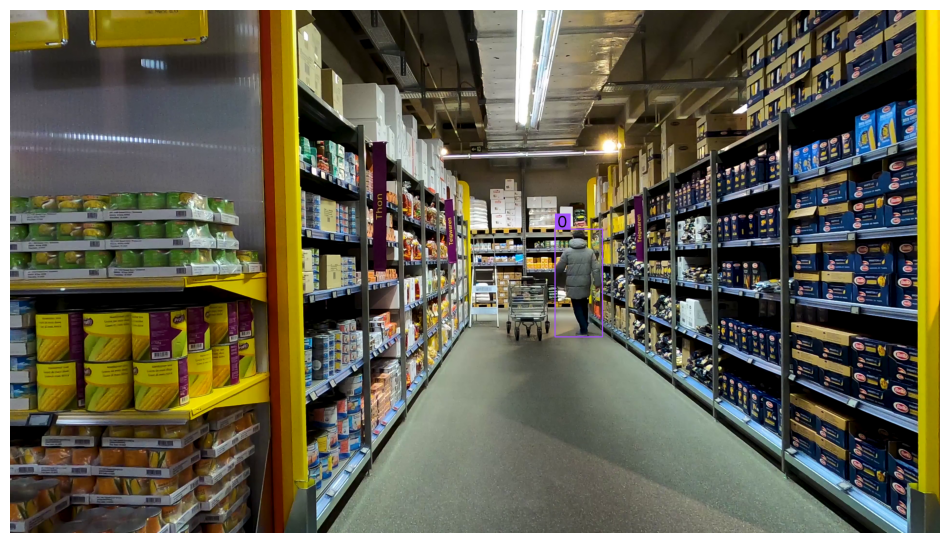

In [11]:
frame = next(generator)

# 2. Detectar objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results) # para facilitar a sua vida e você sair com seu conjuge
detections = detections[detections.class_id == 0] # filtrando os resultados (apenas pessoas -> class_id == 0)

# 3 Anotar as informações relevantes
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2) # criando a minha anotação
box_annotator.annotate(scene=frame, detections=detections)  # de fato anoto em cima do frame (imagem)

%matplotlib inline
sv.plot_image(image=frame, size=(12, 12))

In [12]:
frame = next(generator)

# 1. Criar Modelo
model = YOLO("yolov8s.pt")

# 2. Detectar objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results) # para facilitar a sua vida e você sair com seu cônjuge
detections = detections[detections.class_id == 0]


# 3. Anotar as informações relevantes

# 3.1 Criar zona de monitoramento
polygon = np.array([
    [1312, 2150],
    [1920, 1274],
    [2372, 1258],
    [3548, 2146],
    [1308, 2150]
    ])

# extrair informaçÕes do meu vídeo
video_info = sv.VideoInfo.from_video_path(video_path=MALL_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)


0: 736x1280 1 person, 3 bottles, 1 chair, 2 tvs, 2 refrigerators, 8.2ms
Speed: 6.9ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


In [13]:
detections


Detections(xyxy=array([[     2245.9,      911.33,      2441.3,      1350.4]], dtype=float32), mask=None, confidence=array([     0.9034], dtype=float32), class_id=array([0]), tracker_id=None, data={})

<ipython-input-14-ae665ae171d0>:5: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)


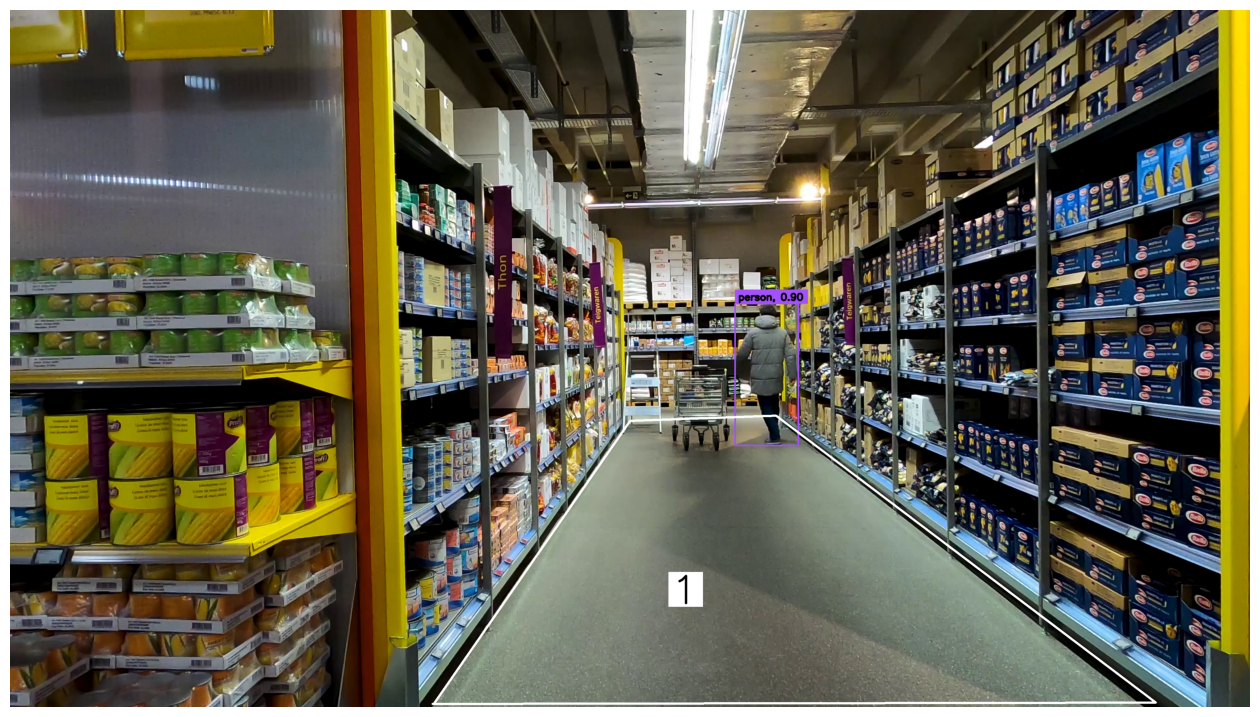

In [14]:
# criar objetos de anotações
labels = [f"{model.names[class_id]}, {confidence:0.2f}" for _, _, confidence, class_id, _ , _ in detections]

box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
zone.trigger(detections=detections)

box_annotator.annotate(scene=frame, detections=detections, labels=labels)
zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(image=frame, size=(16, 16))

## Contador de múltiplos Objetos em vídeo

In [15]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr" -O market-square.mp4 && rm -rf /tmp/cookies.txt

display.clear_output()

!ls

mall.mp4  market-square.mp4  yolov8s.pt


In [16]:
VIDEO_PATH = f"market-square.mp4"

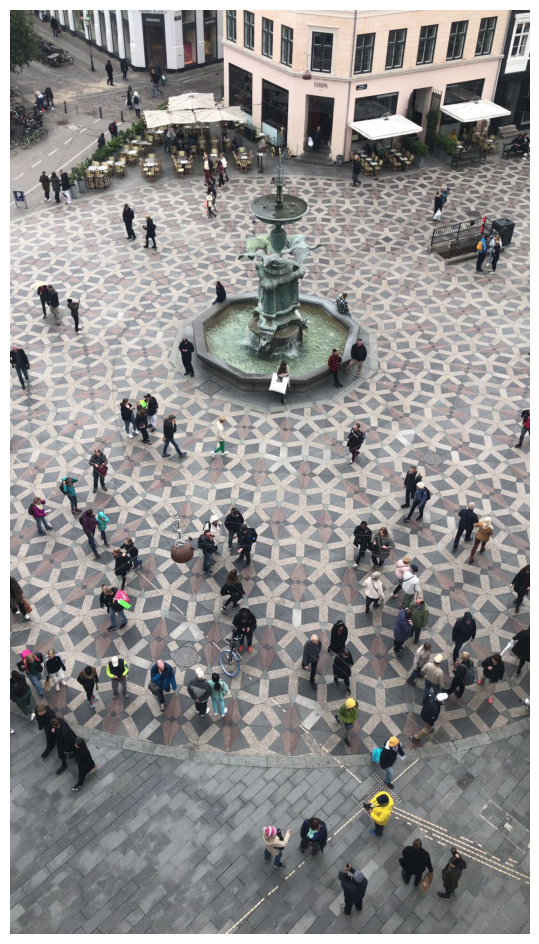

True

In [17]:
generator = sv.get_video_frames_generator(VIDEO_PATH)

frame = next(generator)

sv.plot_image(frame)

cv2.imwrite("frame_reference.jpg", frame)

100%|██████████| 49.7M/49.7M [00:00<00:00, 298MB/s]



0: 1280x736 100 persons, 2 bicycles, 2 benchs, 3 backpacks, 2 umbrellas, 3 chairs, 1 potted plant, 154.3ms
Speed: 7.9ms preprocess, 154.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


<ipython-input-18-df46cf7a7f4a>:26: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)


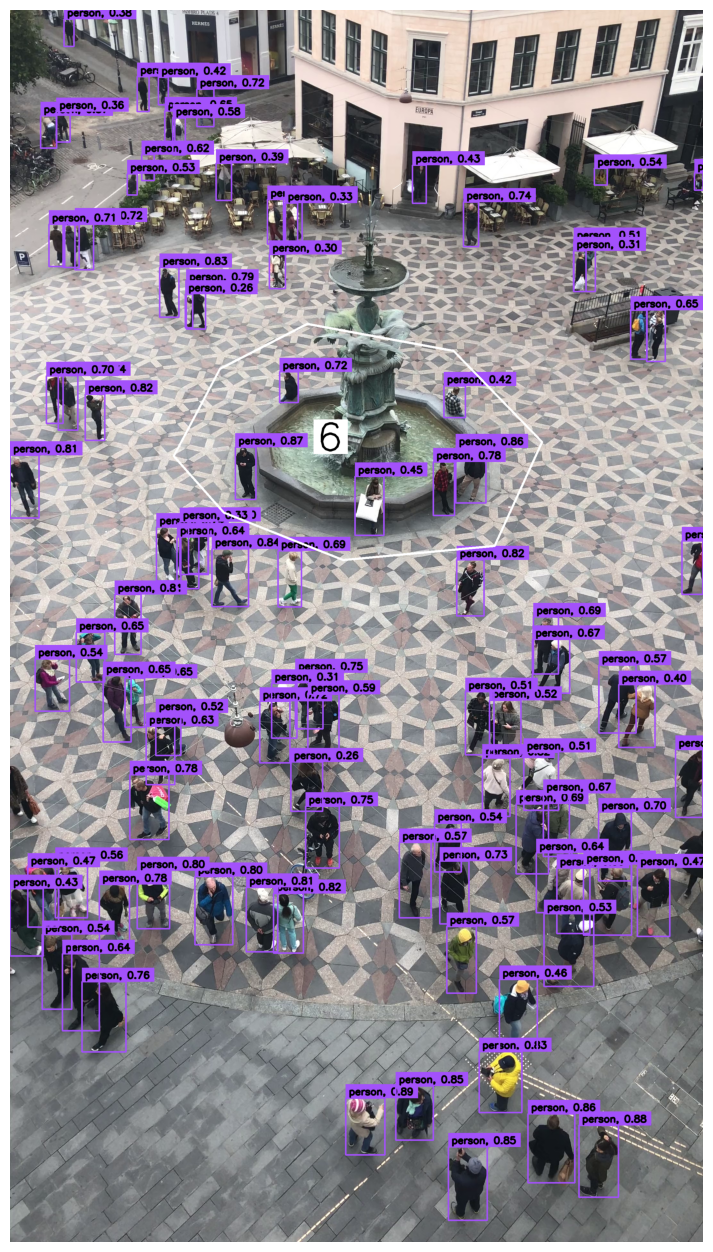

In [18]:
frame = next(generator)

# 1. Criar Modelo
model = YOLO("yolov8m.pt")

# 2. Detectar objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results) # para facilitar a sua vida e você sair com seu cônjuge
detections = detections[detections.class_id == 0]


# 3. Anotar as informações relevantes

# 3.1 Criar zona de monitoramento
polygon = np.array([
[654, 1118],[510, 1390],[666, 1566],[1038, 1714],[1510, 1670],[1658, 1346],[1382, 1062],[926, 978],[654, 1118]
])

# extrair informaçÕes do meu vídeo
video_info = sv.VideoInfo.from_video_path(video_path = VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# criar objetos de anotações
labels = [f"{model.names[class_id]}, {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
zone.trigger(detections=detections)

box_annotator.annotate(scene=frame, detections=detections, labels=labels)
zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(image=frame, size=(16, 16))


0: 1280x736 100 persons, 2 bicycles, 2 benchs, 3 backpacks, 2 umbrellas, 1 handbag, 1 sports ball, 3 chairs, 2 potted plants, 18.1ms
Speed: 7.6ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 736)


<ipython-input-19-06fd070123fd>:28: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)


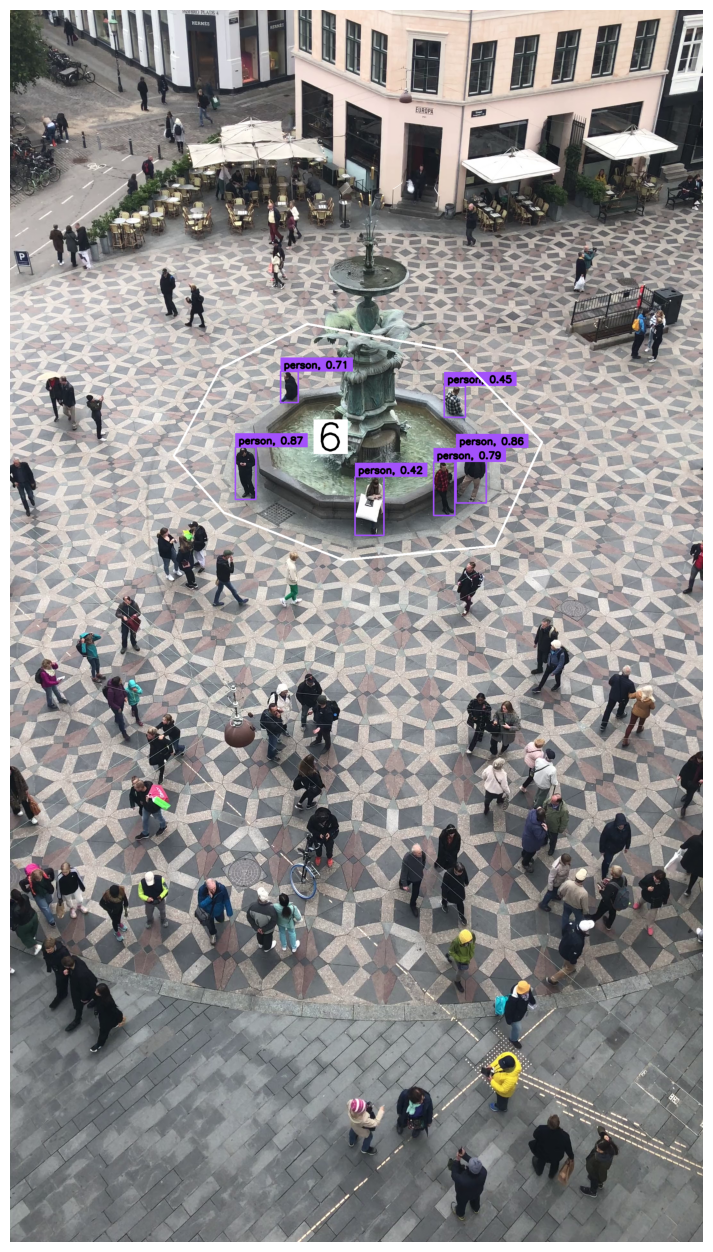

In [19]:
# 1. Criar Modelo
model = YOLO("yolov8m.pt")

frame = next(generator)

# 2. Detectar objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# 3. Anotar as informações relevantes

# 3.1 Criar zona de monitoramento
polygon = np.array([
[654, 1118],[510, 1390],[666, 1566],[1038, 1714],[1510, 1670],[1658, 1346],[1382, 1062],[926, 978],[654, 1118]
])

# extrair informaçÕes do meu vídeo
video_info = sv.VideoInfo.from_video_path(video_path = VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

mask = zone.trigger(detections=detections)

detections = detections[(detections.class_id == 0) & mask]

# criar objetos de anotações
labels = [f"{model.names[class_id]}, {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
# zone.trigger(detections=detections)

box_annotator.annotate(scene=frame, detections=detections, labels=labels)
zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(image=frame, size=(16, 16))

In [20]:
def process_frame(frame: np.array, _) -> np.array:
    # 2. Detectar objetos
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_ultralytics(results)

    # 3. Anotar as informações relevantes

    # 3.1 Criar zona de monitoramento
    polygon = np.array([
    [654, 1118],[510, 1390],[666, 1566],[1038, 1714],[1510, 1670],[1658, 1346],[1382, 1062],[926, 978],[654, 1118]
    ])

    # extrair informaçÕes do meu vídeo
    video_info = sv.VideoInfo.from_video_path(video_path = VIDEO_PATH)
    zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

    mask = zone.trigger(detections=detections)

    detections = detections[(detections.class_id == 0) & mask]

    # criar objetos de anotações
    labels = [f"{model.names[class_id]}, {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
    zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
    # zone.trigger(detections=detections)

    box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=VIDEO_PATH, target_path=f"/content/result.mp4", callback=process_frame)


0: 1280x736 97 persons, 1 bicycle, 1 bench, 2 backpacks, 2 umbrellas, 1 suitcase, 3 chairs, 3 potted plants, 27.9ms
Speed: 43.0ms preprocess, 27.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


<ipython-input-20-79630f346c53>:24: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)



0: 1280x736 100 persons, 2 bicycles, 2 benchs, 3 backpacks, 2 umbrellas, 3 chairs, 1 potted plant, 51.6ms
Speed: 24.4ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 736)

0: 1280x736 100 persons, 2 bicycles, 2 benchs, 3 backpacks, 2 umbrellas, 1 handbag, 1 sports ball, 3 chairs, 2 potted plants, 33.1ms
Speed: 18.3ms preprocess, 33.1ms inference, 2.1ms postprocess per image at shape (1, 3, 1280, 736)

0: 1280x736 102 persons, 2 bicycles, 2 benchs, 3 backpacks, 2 umbrellas, 3 handbags, 2 chairs, 2 potted plants, 1 dining table, 17.7ms
Speed: 16.4ms preprocess, 17.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 736)

0: 1280x736 100 persons, 2 bicycles, 1 bench, 4 backpacks, 2 umbrellas, 3 chairs, 1 potted plant, 1 dining table, 18.3ms
Speed: 12.3ms preprocess, 18.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 736)

0: 1280x736 101 persons, 1 bicycle, 1 motorcycle, 1 bench, 3 backpacks, 2 umbrellas, 1 sports ball, 3 ch